In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import re
import string

from nltk.corpus import stopwords
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

### Explanatory data analysis

Dataset loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

### First checking the number of missing values
Instead of simply getting the number of Nans i`ll plot it in a heatmap, it helps understand how are the missing values distributed

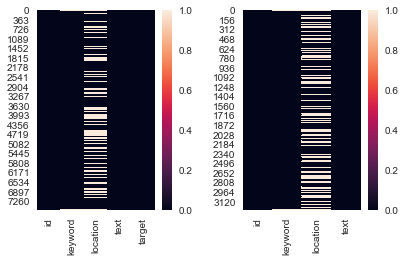

In [4]:
nans = train.isna()
nansTest = test.isna()
plt.subplot(1,2,1)
sns.heatmap(nans)
plt.subplot(1,2,2)
sns.heatmap(nansTest)
plt.tight_layout(pad = 2)
plt.show()

We can see that there is a tiny class imbalance

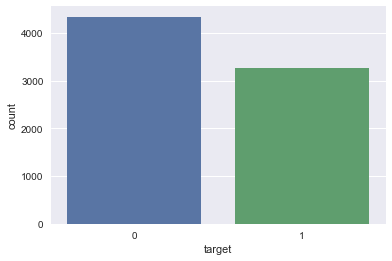

In [5]:
sns.countplot(data=train, x= 'target');

I've decided to check some basic information about the tweets
By plotting some of the features extracted from the tweets we can generate some insights

1. The length of the tweets for non disaster is bigger than the length for disaster tweets.
2. Word count follows the same rule (non disaster tweets have more words than real disaster ones)
3. Mean word length is basically the same as the ones above
4. However we can see that real disaster tweets have bigger average word length

It's difficult to say exactly why we see the information above on the dataset, one of the things we might actually suppose is that when people are posting about real disaster they are normally in a hurry or they simply want to post the information as soon as possible, not spending their time describing the details of how it happened.
In the other hand when people are not facing a disaster they kind of "loose time" talking about every kind of stuff they might actually be interested in

<AxesSubplot:title={'center':'Mean word length of the tweets'}, xlabel='target', ylabel='meanWordLen'>

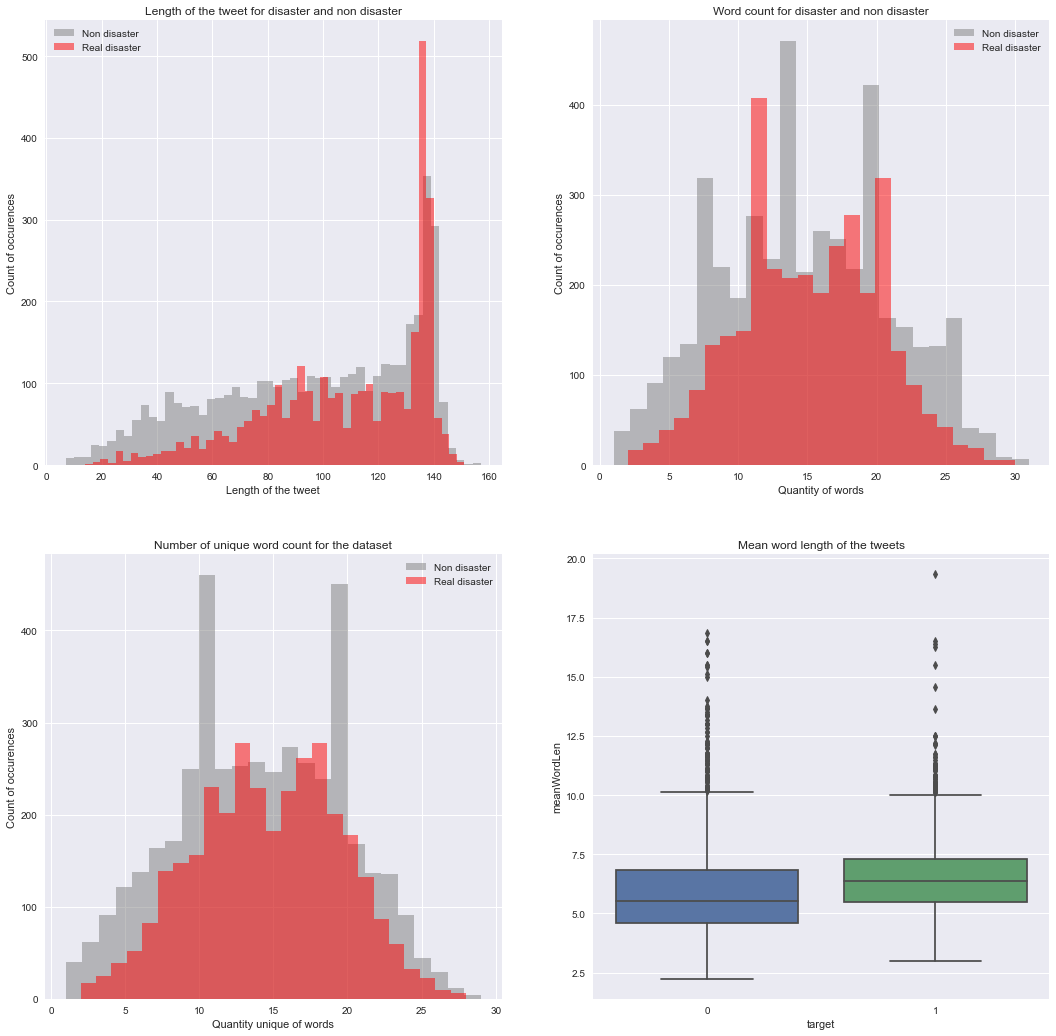

In [6]:
train['TweetLen'] = train['text'].map(lambda x: len(x))
train['WordCount'] = train['text'].map(lambda x: len(x.split()))
train['UniqueWordCnt'] = train['text'].map(lambda x: len(set(x.split())))
def meanWordLen(text):
    words = [len(word) for word in text.split()]
    return np.mean(words)
train['meanWordLen'] = train['text'].map(meanWordLen)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (18,18))
ax[0,0].set_title('Length of the tweet for disaster and non disaster')
ax[0,0].set_xlabel('Length of the tweet')
ax[0,0].set_ylabel('Count of occurences')
ax[0,0].hist(train[train['target'] == 0]['TweetLen'],bins = 50, label = 'Non disaster', color = 'grey', alpha = 0.5)
ax[0,0].hist(train[train['target'] == 1]['TweetLen'],bins = 50, label = 'Real disaster', color = 'r', alpha = 0.5)
ax[0,0].legend()

ax[0,1].set_title('Word count for disaster and non disaster')
ax[0,1].set_xlabel('Quantity of words')
ax[0,1].set_ylabel('Count of occurences')
ax[0,1].hist(train[train['target'] == 0]['WordCount'],bins = 25, label = 'Non disaster', color = 'grey', alpha = 0.5)
ax[0,1].hist(train[train['target'] == 1]['WordCount'],bins = 25, label = 'Real disaster', color = 'r', alpha = 0.5)
ax[0,1].legend()

ax[1,0].set_title('Number of unique word count for the dataset')
ax[1,0].set_xlabel('Quantity unique of words')
ax[1,0].set_ylabel('Count of occurences')
ax[1,0].hist(train[train['target'] == 0]['UniqueWordCnt'],bins = 25, label = 'Non disaster', color = 'grey', alpha = 0.5)
ax[1,0].hist(train[train['target'] == 1]['UniqueWordCnt'],bins = 25, label = 'Real disaster', color = 'r', alpha = 0.5)
ax[1,0].legend()

ax[1,1].set_title('Mean word length of the tweets')
sns.boxplot(data=train, y = 'meanWordLen', x =  'target', ax = ax[1,1])

In [7]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

stop = set(stopwords.words('english'))
def removeStop(text):
    words = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(words)

### Basic treatment for text classification
We are removing URL, Emojis, punctuation stop words and so on the object is to clean up the text for machine learning

In [8]:
train['textTreated'] = train['text'].map(remove_URL)
train['textTreated'] = train['textTreated'].map(remove_html)
train['textTreated'] = train['textTreated'].map(remove_emoji)
train['textTreated'] = train['textTreated'].map(remove_punct)
train['textTreated'] = train['textTreated'].map(removeStop)

test['textTreated'] = test['text'].map(remove_URL)
test['textTreated'] = test['textTreated'].map(remove_html)
test['textTreated'] = test['textTreated'].map(remove_emoji)
test['textTreated'] = test['textTreated'].map(remove_punct)
test['textTreated'] = test['textTreated'].map(removeStop)

In [9]:
train.head()

,id,keyword,location,text,target,TweetLen,WordCount,UniqueWordCnt,meanWordLen,textTreated
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,13,4.384615,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,7,4.571429,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,20,5.090909,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,8,7.125000,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,15,4.500000,got sent photo ruby alaska smoke wildfires pou...


In [10]:
def createCorpus(texts):
    words = []
    for text in texts:
        for word in text.split():
            words.append(word)
    return words
corpusNonDisaster = createCorpus(train[train['target'] == 0]['textTreated'])
corpusDisaster = createCorpus(train[train['target'] == 1]['textTreated'])

I'm gonna create a word cloud based on the the most frequent words for both disaster and non disaster tweets
and i'm gonna make it only after the text is treated otherwise the word cloud will be completely poluted with stop words and other useless stuff

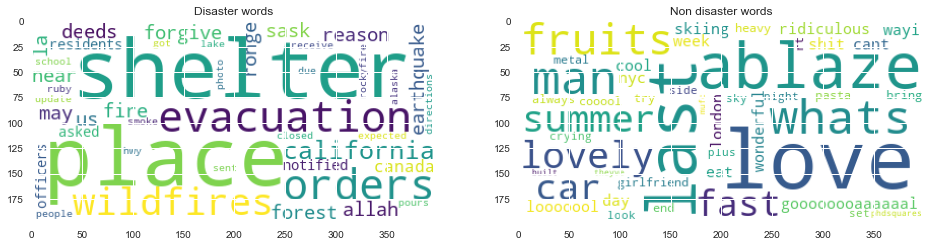

In [11]:
word_cloud0 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpusNonDisaster[:50])
)
word_cloud1 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpusDisaster[:50])
)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Disaster words')
plt.imshow(word_cloud1)
plt.subplot(1, 2, 2)
plt.title('Non disaster words')
plt.imshow(word_cloud0);

There are several methods that can be used here, the idea is to create ngrams groups of words that will help us understand the meaning of each tweet
these can be groups of 1, 2, 3 ...n words
In order to help us with this task there are some usefull methods, some of them are:
CountVectorizer
TfIdfVectorizer
what i'm gonna do here is to basically write some code to compare them both.

After doing so what i'm gonna do is reduce it's dimensionality with truncated SVD so that i can produce a scatter plot of them both and compare them

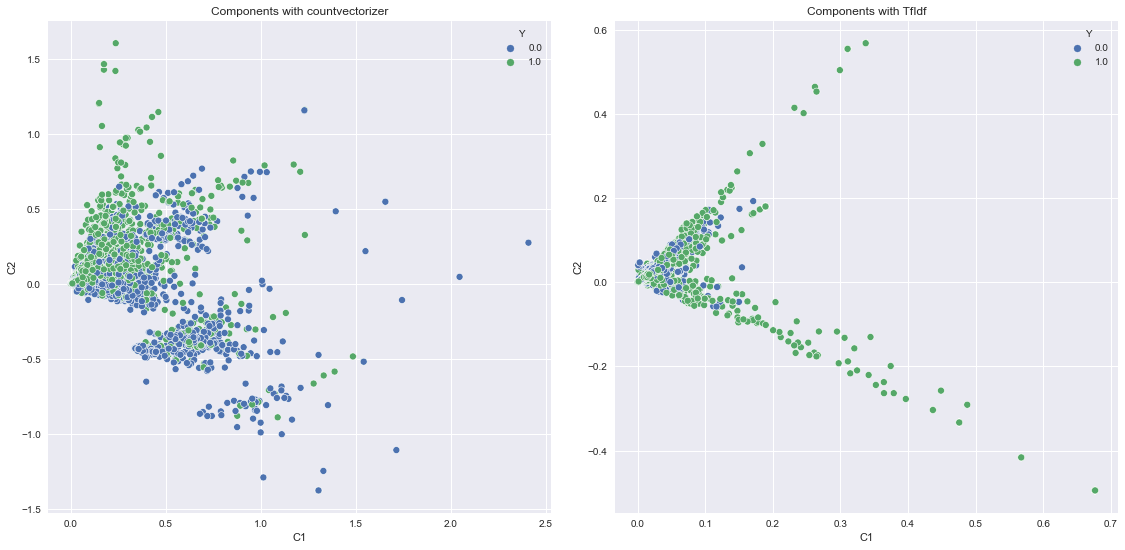

In [12]:
def compareMethods(ngram = (1,1)):
    counter = CountVectorizer(ngram_range=ngram)
    trainCounts = counter.fit_transform(train['textTreated'])
    testCounts = counter.transform(test['textTreated'])

    tfidfVect = TfidfVectorizer(ngram_range=ngram)
    trainTFIdf = tfidfVect.fit_transform(train['textTreated'])
    testTFIdf = tfidfVect.transform(test['textTreated'])

    svd = TruncatedSVD(n_components=2)
    compCounts = svd.fit_transform(trainCounts)
    compTFIdf = svd.fit_transform(trainTFIdf)

    dfCount = pd.DataFrame(np.concatenate((compCounts, train.target.values.reshape(compCounts.shape[0],1)),axis = 1), columns=['C1','C2','Y'])
    dfTfIdf = pd.DataFrame(np.concatenate((compTFIdf, train.target.values.reshape(compTFIdf.shape[0],1)),axis = 1), columns=['C1','C2','Y'])
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title('Components with countvectorizer')
    sns.scatterplot(data=dfCount,x = 'C1', y='C2', hue = 'Y');

    plt.subplot(1,2,2)
    plt.title('Components with TfIdf')
    sns.scatterplot(data=dfTfIdf,x = 'C1', y='C2', hue = 'Y');
    plt.tight_layout(pad = 2)
    plt.show();
compareMethods()

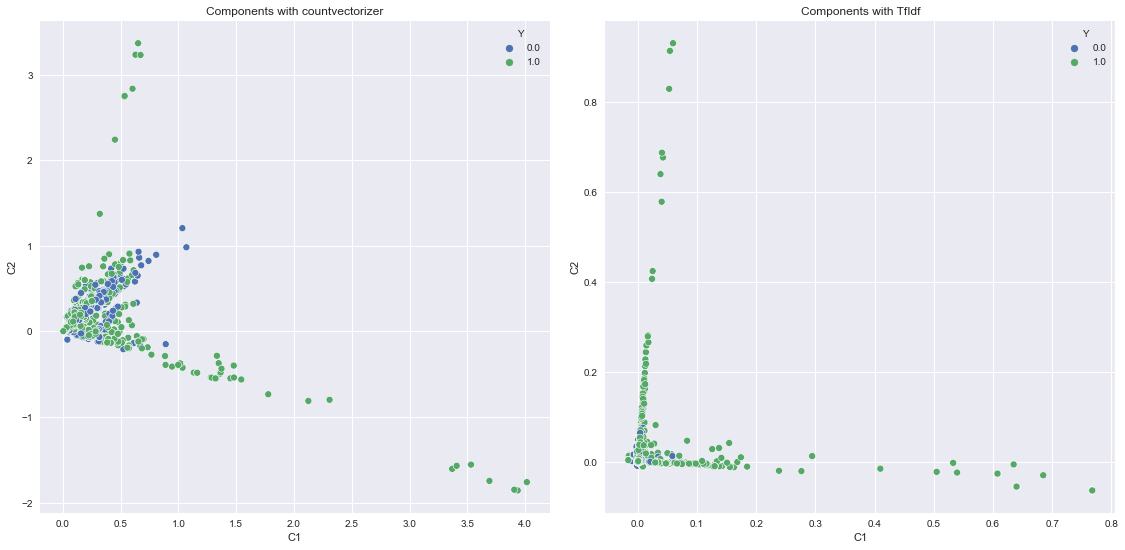

In [13]:
compareMethods((1,2))

The official metric for this competition is f1-Score so i created a function which trains a model and evaluate this metric

In [14]:
counter = CountVectorizer(ngram_range=(1,2))
trainCounts = counter.fit_transform(train['textTreated'])
def trainAndEval(X, y, model):
    cv = cross_val_score(model, X = X, y=y, cv=5, n_jobs=-1, scoring = 'f1')
    print(f"F1 score = {cv.max()}")
model = LogisticRegression(class_weight="balanced")
trainAndEval(X = trainCounts, y = train.target.values, model=model)

F1 score = 0.6901062959934587


In [15]:
tfidfVect = TfidfVectorizer(ngram_range=(1,1))
trainTFIdf = tfidfVect.fit_transform(train['textTreated'])
model = LogisticRegression(class_weight="balanced")
trainAndEval(X = trainTFIdf, y = train.target.values, model=model)

F1 score = 0.718944099378882


First by comparing CountVectorizer and TfIdf and using LogisticRegression as the basic machine learning model we can see the TfIdf performs a little bit better